In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pykrx import stock
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

In [323]:
#Kospi200 지수를 yf로 부터 가져옴
kospi200 = yf.download("^KS200", start="2020-01-01", end="2025-09-13")
kospi200.columns=kospi200.columns.droplevel(level=1)

[*********************100%***********************]  1 of 1 completed


In [324]:
#만기일의 KOSPI200 데이터만 추출해서 kospi200_selected df 만들기

# 분석할 기간 설정
start = kospi200.index[0]
end = kospi200.index[-1]

# 매달 둘째 주 목요일 추출
dates = pd.date_range(start=start, end=end, freq="W-THU")  # 모든 목요일
second_thu = dates.to_series().groupby([dates.year, dates.month]).nth(1)  # 각 월별 2번째 목요일
thu_list = pd.DatetimeIndex(second_thu.to_list())

adj_thu_list = []

for d in thu_list:
    # kospi200.index 중 d 이상인 첫 번째 날짜 찾기
    next_day = kospi200.index[kospi200.index.get_indexer([d], method="backfill")][0]
    adj_thu_list.append(next_day)

adj_thu_list = pd.DatetimeIndex(adj_thu_list)
#만기일의 KOSPI200 지수 데이터 추출
kospi200_selected=kospi200.loc[kospi200.index.intersection(adj_thu_list)]

In [325]:
#만기일 Close 값 보다 일정 수준 이상인 OTM 지수 산출하여 컬럼 만들기
otm_call=['3%','5%','7%','10%'] # 콜옵션 OTM 비율 --> ###%%% 주요변수 입력 창 ######
for otm in otm_call:
    kospi200_selected[f'call_{otm}'] = round(kospi200_selected['Close'] * (1 + float(otm.strip('%'))/100)/2.5)*2.5

Text(0.5, 0, 'YEAR')

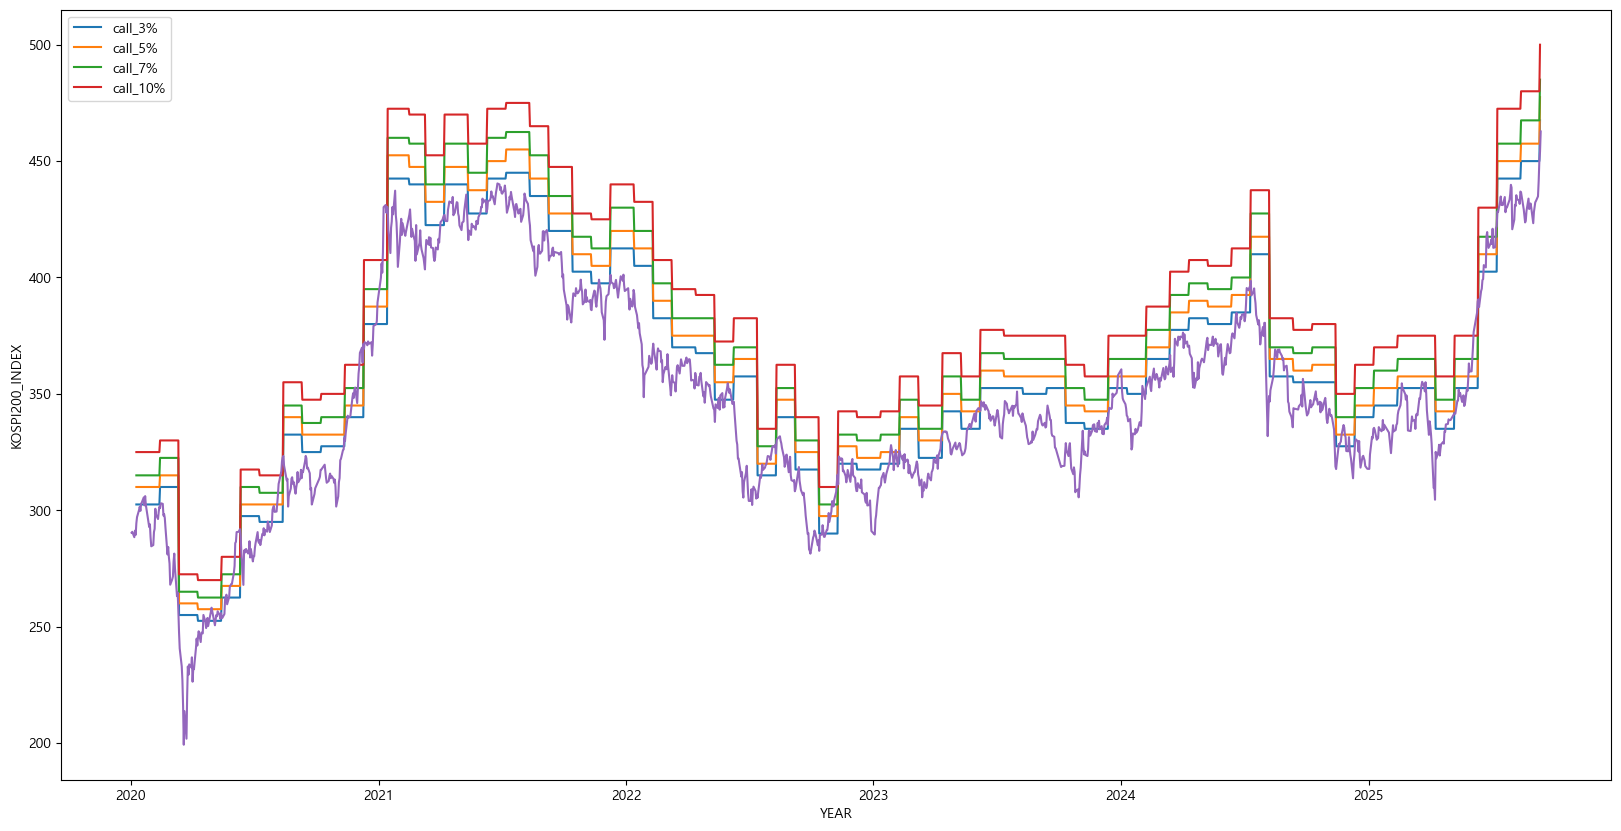

In [326]:
# 산출된 OTM 지수와 kospi200 지수와의 관계 보기(그래프)
plt.figure(figsize=(20,10))
col_name=[str("call_") + name  for name in otm_call]
kospi200_call=kospi200_selected.asfreq('D', method='ffill')[col_name]
for i in range(len(col_name)):
    sns.lineplot(kospi200_call, x=kospi200_call.index, y=col_name[i], label=col_name[i])
sns.lineplot(kospi200, x=kospi200.index, y='Close')
plt.ylabel('KOSPI200_INDEX')
plt.xlabel('YEAR')

In [327]:
kospi200_selected

Price,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0
...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0


In [328]:
due_dates=kospi200_selected.index.to_list()
dates=[str(date)[0:10].replace('-','') for date in due_dates]

In [329]:
# 옵션 가격 데이터 가져오기/저장하기
# due_dates=kospi200_selected.index.to_list()
# dates=[str(date)[0:10].replace('-','') for date in due_dates]
# option_price_data = {}
# for date in dates:
#     data = stock.get_future_ohlcv(date, 'KRDRVOPK2I')
#     option_price_data[date]=data

import pickle
# with open('option_price_data.pkl', 'wb') as f:
#     pickle.dump(option_price_data, f)

In [330]:
#저장된 옵션 가격데이터 불러오기
with open('option_price_data.pkl', 'rb') as f:
    option_price_data = pickle.load(f)

In [331]:
def get_option_price(column_name):
    price_name=[]
    for i in range(len(kospi200_selected)):
        price_code=(kospi200_selected.index[i]+pd.Timedelta(days=30)).strftime('%Y%m')+str(' ')+str(kospi200_selected[column_name][i])
        price_codes = '코스피200 C'+str(' ')+price_code+str(' (주간)')
        price_name.append(price_codes)

    price_list=[]
    for j in range(len(price_name)):
        price=option_price_data[dates[j]][option_price_data[dates[j]]['종목명'] == price_name[j]]['종가'].values
        if len(price)==0:
            price=np.nan
        else:
            price=price[0]
        price_list.append(price)

    df_price_tmp=pd.DataFrame(price_list, columns=[f'{column_name}_price'], index=kospi200_selected.index)
    return df_price_tmp   

In [332]:
for name in col_name:
    kospi200_selected=pd.concat([kospi200_selected, get_option_price(name)], axis=1)

In [333]:
kospi200_selected

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,call_5%_price,call_7%_price,call_10%_price
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0,1.85,0.58,0.22,0.03
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0,1.60,0.73,0.18,0.04
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5,6.72,5.05,3.69,2.25
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0,5.45,3.59,2.59,1.26
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0,2.03,0.99,0.43,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0,2.92,1.75,0.77,0.25
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0,4.13,2.37,1.32,0.46
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5,4.50,2.76,1.67,0.56
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0,3.32,1.81,0.76,0.27


<Axes: ylabel='call_3%_price'>

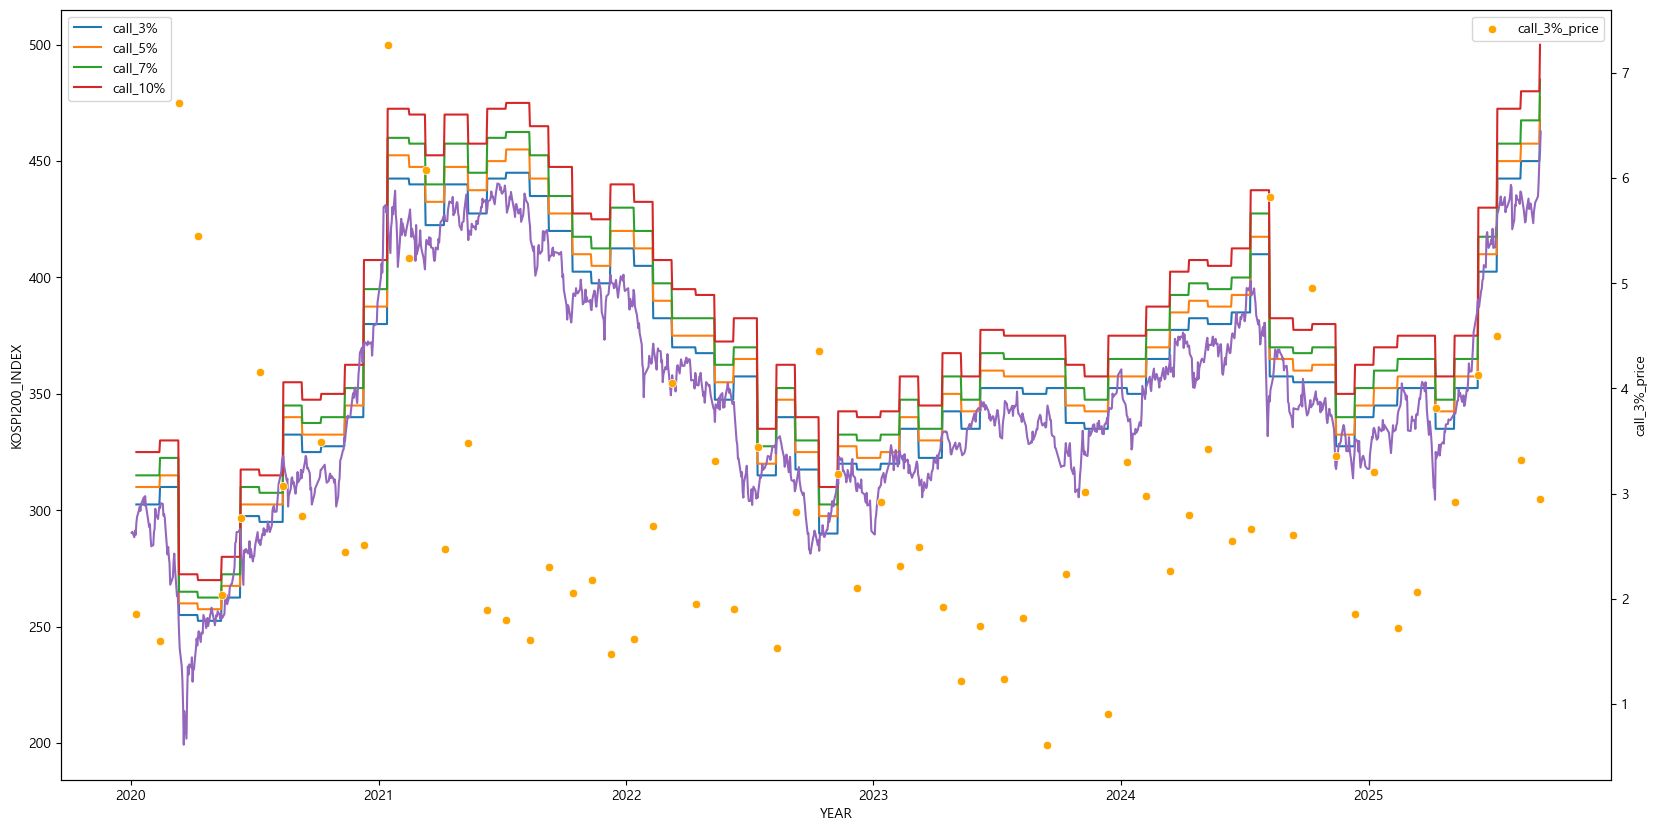

In [334]:

plt.figure(figsize=(20,10))

col_name=[str("call_") + name  for name in otm_call]
kospi200_call=kospi200_selected.asfreq('D', method='ffill')[col_name]
for i in range(len(col_name)):
    sns.lineplot(kospi200_call, x=kospi200_call.index, y=col_name[i], label=col_name[i])
sns.lineplot(kospi200, x=kospi200.index, y='Close')
plt.ylabel('KOSPI200_INDEX')
plt.xlabel('YEAR')

ax2 = plt.twinx()
sns.scatterplot(data=kospi200_selected, x=kospi200_selected.index, y='call_3%_price', ax=ax2, color='orange', label='call_3%_price')

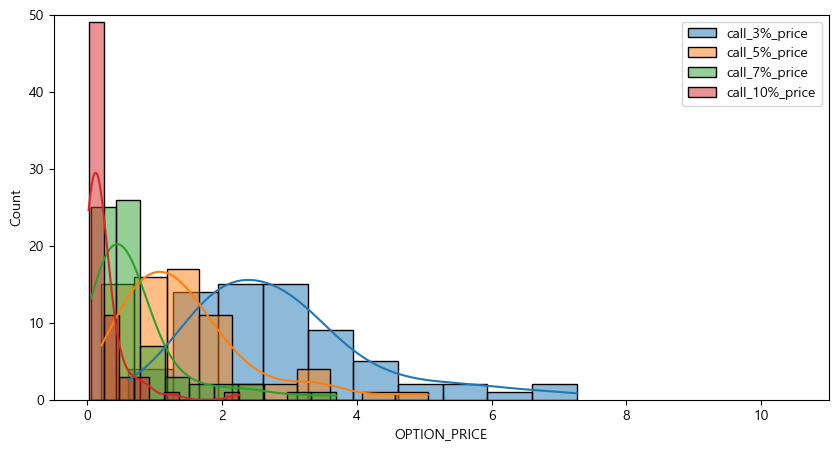

In [409]:
plt.figure(figsize=(10,5))
sns.histplot(kospi200_selected['call_3%_price'], bins=10, kde=True, label='call_3%_price') 
sns.histplot(kospi200_selected['call_5%_price'], bins=10, kde=True, label='call_5%_price') 
sns.histplot(kospi200_selected['call_7%_price'], bins=10, kde=True, label='call_7%_price') 
sns.histplot(kospi200_selected['call_10%_price'], bins=10, kde=True, label='call_10%_price')
plt.xlim(-0.5,11)
plt.ylim(0,50)
plt.xlabel('OPTION_PRICE')
plt.legend()

In [336]:
for otm in otm_call:
    kospi200_selected[f'call_{otm}_result']=np.where(kospi200_selected['Close'].shift(-1)<kospi200_selected[f'call_{otm}'], kospi200_selected[f'call_{otm}_price'], 
         kospi200_selected[f'call_{otm}']-kospi200_selected['Close'].shift(-1))


In [337]:
kospi200_selected.head().round(1)

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,call_5%_price,call_7%_price,call_10%_price,call_3%_result,call_5%_result,call_7%_result,call_10%_result
2020-01-09,294.4,294.4,292.1,293.8,111800000,302.5,310.0,315.0,325.0,1.8,0.6,0.2,0.0,1.8,0.6,0.2,0.0
2020-02-13,300.9,304.4,300.5,302.8,115100000,310.0,315.0,322.5,330.0,1.6,0.7,0.2,0.0,1.6,0.7,0.2,0.0
2020-03-12,247.6,255.5,243.8,253.9,242500000,255.0,260.0,265.0,272.5,6.7,5.0,3.7,2.2,6.7,5.0,3.7,2.2
2020-04-09,245.6,246.5,243.1,246.1,175900000,252.5,257.5,262.5,270.0,5.4,3.6,2.6,1.3,-1.1,3.6,2.6,1.3
2020-05-14,253.6,254.4,252.1,253.3,167600000,262.5,267.5,272.5,280.0,2.0,1.0,0.4,0.1,-26.1,-21.1,-16.1,-8.6


In [338]:
result_columns=[n for n in kospi200_selected.columns if 'result' in n ]
result = kospi200_selected[result_columns]

In [339]:
for col in result.columns:
    result[col+'_cumsum']=result[col].cumsum()

Text(0, 0.5, 'KOSPI200_INDEX')

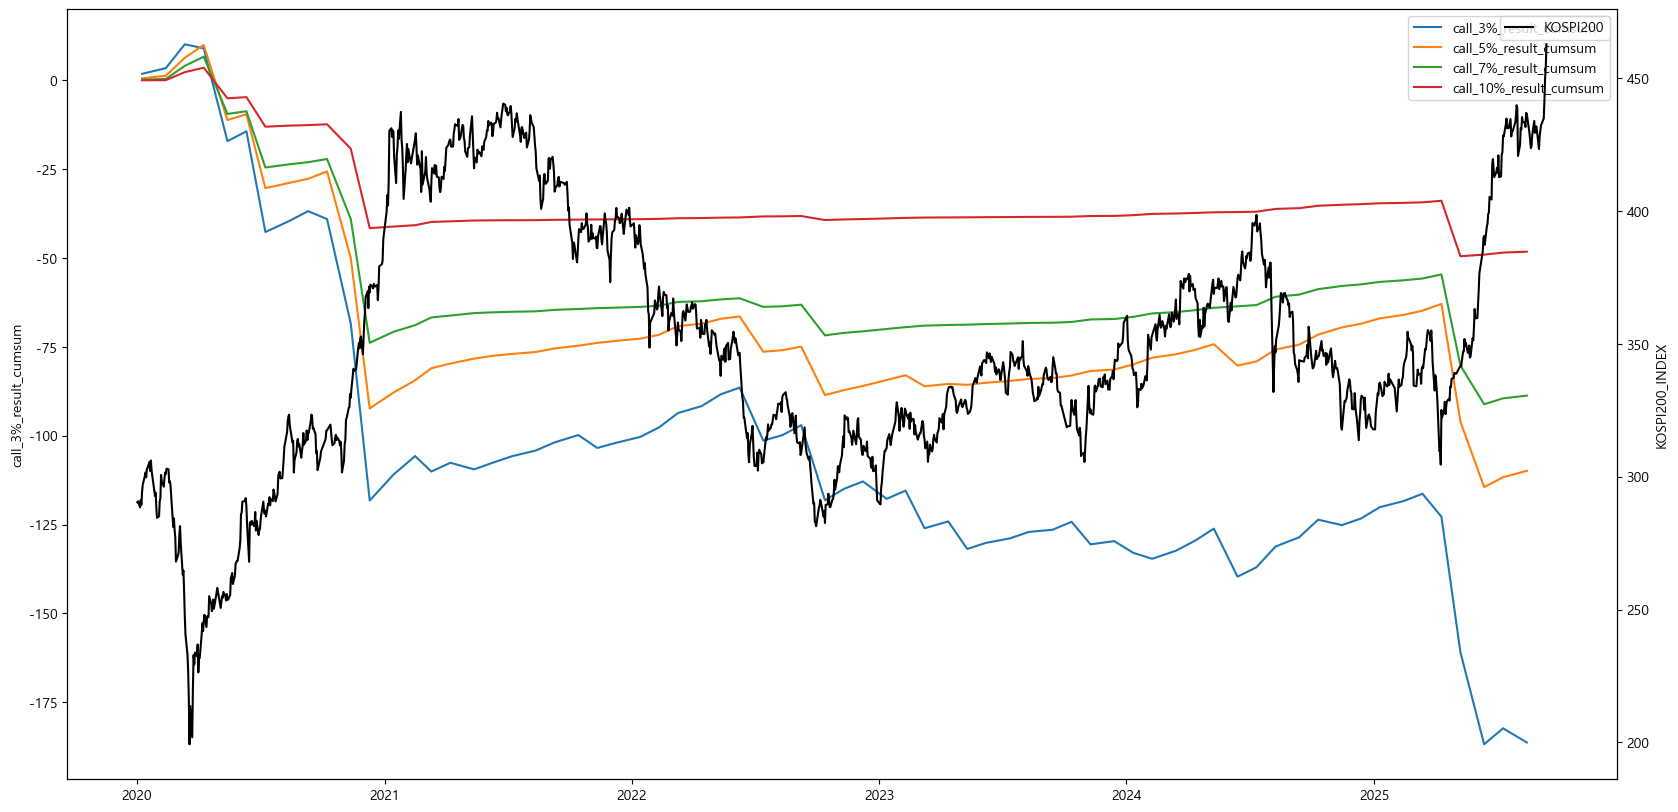

In [340]:
cumsum_columns = [ m for m in result.columns if 'cumsum' in m ]
plt.figure(figsize=(20,10))
for col in cumsum_columns:
    sns.lineplot(result, x=result.index, y=col, label=col)

ax2=plt.twinx()
sns.lineplot(kospi200, x=kospi200.index, y='Close', color='black', label='KOSPI200')
plt.xlabel('YEAR')
plt.ylabel('CUMSUM')
ax2.set_ylabel('KOSPI200_INDEX')

In [341]:
#만기일 Close 값 보다 일정 수준 이상인 OTM 지수 산출하여 컬럼 만들기
otm_put=['3%','5%','7%','10%'] # 콜옵션 OTM 비율 --> ###%%% 주요변수 입력 창 ######
for otm in otm_call:
    kospi200_selected[f'put_{otm}'] = round(kospi200_selected['Close'] * (1 - float(otm.strip('%'))/100)/2.5)*2.5

In [342]:
kospi200_selected

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,...,call_7%_price,call_10%_price,call_3%_result,call_5%_result,call_7%_result,call_10%_result,put_3%,put_5%,put_7%,put_10%
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0,1.85,...,0.22,0.03,1.850000,0.580000,0.220000,0.030000,285.0,280.0,275.0,265.0
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0,1.60,...,0.18,0.04,1.600000,0.730000,0.180000,0.040000,292.5,285.0,280.0,270.0
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5,6.72,...,3.69,2.25,6.720000,5.050000,3.690000,2.250000,240.0,235.0,230.0,222.5
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0,5.45,...,2.59,1.26,-1.149994,3.590000,2.590000,1.260000,237.5,232.5,227.5,220.0
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0,2.03,...,0.43,0.13,-26.119995,-21.119995,-16.119995,-8.619995,245.0,240.0,235.0,227.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0,2.92,...,0.77,0.25,-38.119995,-33.119995,-25.619995,-15.619995,330.0,325.0,317.5,307.5
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0,4.13,...,1.32,0.46,-25.920013,-18.420013,-10.920013,0.460000,380.0,370.0,362.5,352.5
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5,4.50,...,1.67,0.56,4.500000,2.760000,1.670000,0.560000,415.0,407.5,397.5,385.0
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0,3.32,...,0.76,0.27,-4.000000,1.810000,0.760000,0.270000,422.5,415.0,405.0,392.5


In [343]:
col_name2=[str("put_") + name  for name in otm_put]

In [344]:
option_price_data[dates[0]]

,종목명,종가,대비,시가,고가,저가,현물가,거래량,거래대금
종목코드,,,,,,,,,
201Q1212,코스피200 C 202001 212.5 (주간),80.0,3.05,80.0,80.0,80.0,0.00,3,60000000
201Q1215,코스피200 C 202001 215.0 (주간),0.0,0.00,0.0,0.0,0.0,0.00,0,0
201Q1217,코스피200 C 202001 217.5 (주간),0.0,0.00,0.0,0.0,0.0,0.00,0,0
201Q1220,코스피200 C 202001 220.0 (주간),0.0,0.00,0.0,0.0,0.0,0.00,0,0
201Q1222,코스피200 C 202001 222.5 (주간),0.0,0.00,0.0,0.0,0.0,0.00,0,0
...,...,...,...,...,...,...,...,...,...
301SC320,코스피200 P 202212 320.0 (주간),0.0,0.00,0.0,0.0,0.0,48.30,0,0
301SC330,코스피200 P 202212 330.0 (주간),0.0,0.00,0.0,0.0,0.0,55.25,0,0
301SC340,코스피200 P 202212 340.0 (주간),0.0,0.00,0.0,0.0,0.0,62.25,0,0


In [345]:
def get_p_option_price(column_name):
    price_name=[]
    for i in range(len(kospi200_selected)):
        price_code=(kospi200_selected.index[i]+pd.Timedelta(days=30)).strftime('%Y%m')+str(' ')+str(kospi200_selected[column_name][i])
        price_codes = '코스피200 P'+str(' ')+price_code+str(' (주간)')
        price_name.append(price_codes)

    price_list=[]
    for j in range(len(price_name)):
        price=option_price_data[dates[j]][option_price_data[dates[j]]['종목명'] == price_name[j]]['종가'].values
        if len(price)==0:
            price=np.nan
        else:
            price=price[0]
        price_list.append(price)

    df_price_tmp=pd.DataFrame(price_list, columns=[f'{column_name}_price'], index=kospi200_selected.index)
    return df_price_tmp   

In [346]:
for name in col_name2:
    kospi200_selected=pd.concat([kospi200_selected, get_p_option_price(name)], axis=1)

In [347]:
kospi200_selected

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,...,call_7%_result,call_10%_result,put_3%,put_5%,put_7%,put_10%,put_3%_price,put_5%_price,put_7%_price,put_10%_price
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0,1.85,...,0.220000,0.030000,285.0,280.0,275.0,265.0,1.53,0.78,0.40,0.10
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0,1.60,...,0.180000,0.040000,292.5,285.0,280.0,270.0,2.43,1.15,0.70,0.26
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5,6.72,...,3.690000,2.250000,240.0,235.0,230.0,222.5,10.25,8.27,6.67,4.90
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0,5.45,...,2.590000,1.260000,237.5,232.5,227.5,220.0,6.56,5.16,4.26,3.15
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0,2.03,...,-16.119995,-8.619995,245.0,240.0,235.0,227.5,4.06,2.95,2.14,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0,2.92,...,-25.619995,-15.619995,330.0,325.0,317.5,307.5,3.66,2.66,1.66,0.91
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0,4.13,...,-10.920013,0.460000,380.0,370.0,362.5,352.5,4.71,2.51,1.61,0.91
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5,4.50,...,1.670000,0.560000,415.0,407.5,397.5,385.0,5.18,3.45,2.00,1.04
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0,3.32,...,0.760000,0.270000,422.5,415.0,405.0,392.5,4.15,2.72,1.60,0.82


In [348]:
for otm in otm_put:
    kospi200_selected[f'put_{otm}_result']=np.where(kospi200_selected['Close'].shift(-1)>kospi200_selected[f'put_{otm}'], kospi200_selected[f'put_{otm}_price'], 
         kospi200_selected['Close'].shift(-1)-kospi200_selected[f'put_{otm}'])

In [349]:
kospi200_selected

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,...,put_7%,put_10%,put_3%_price,put_5%_price,put_7%_price,put_10%_price,put_3%_result,put_5%_result,put_7%_result,put_10%_result
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0,1.85,...,275.0,265.0,1.53,0.78,0.40,0.10,1.530000,0.780000,0.400000,0.100000
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0,1.60,...,280.0,270.0,2.43,1.15,0.70,0.26,-44.880005,-37.380005,-32.380005,-22.380005
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5,6.72,...,230.0,222.5,10.25,8.27,6.67,4.90,10.250000,8.270000,6.670000,4.900000
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0,5.45,...,227.5,220.0,6.56,5.16,4.26,3.15,6.560000,5.160000,4.260000,3.150000
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0,2.03,...,235.0,227.5,4.06,2.95,2.14,1.35,4.060000,2.950000,2.140000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0,2.92,...,317.5,307.5,3.66,2.66,1.66,0.91,3.660000,2.660000,1.660000,0.910000
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0,4.13,...,362.5,352.5,4.71,2.51,1.61,0.91,4.710000,2.510000,1.610000,0.910000
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5,4.50,...,397.5,385.0,5.18,3.45,2.00,1.04,5.180000,3.450000,2.000000,1.040000
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0,3.32,...,405.0,392.5,4.15,2.72,1.60,0.82,4.150000,2.720000,1.600000,0.820000


In [350]:
result_columns=[n for n in kospi200_selected.columns if 'result' in n ]
result = kospi200_selected[result_columns]

In [352]:
for col in result.columns:
    result[col+'_cumsum']=result[col].cumsum()

In [355]:
result.sum().round(1)

call_3%_result            -186.3
call_5%_result            -109.9
call_7%_result             -88.7
call_10%_result            -48.2
put_3%_result                3.8
put_5%_result               25.4
put_7%_result               16.3
put_10%_result              14.7
call_3%_result_cumsum    -7093.4
call_5%_result_cumsum    -4706.4
call_7%_result_cumsum    -3924.6
call_10%_result_cumsum   -2247.2
put_3%_result_cumsum       -74.3
put_5%_result_cumsum       761.2
put_7%_result_cumsum       364.4
put_10%_result_cumsum      245.2
dtype: float64

Text(0, 0.5, 'KOSPI200_INDEX')

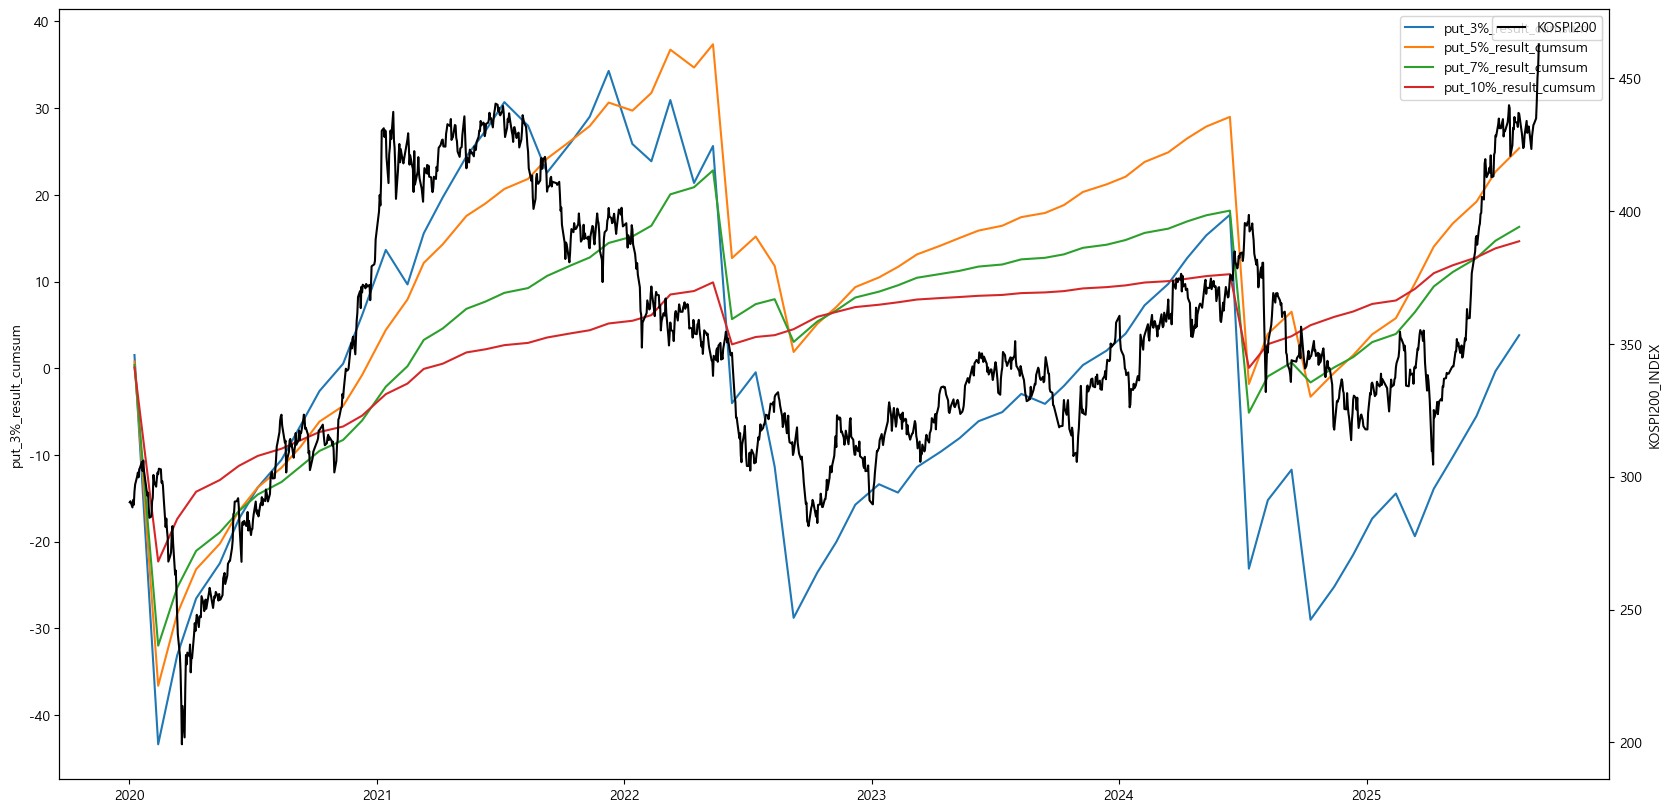

In [358]:
cumsum_columns = [ m for m in result.columns if 'cumsum' in m ]
cumsum_columns = [ m for m in cumsum_columns if 'put' in m ]
plt.figure(figsize=(20,10))
for col in cumsum_columns:
    sns.lineplot(result, x=result.index, y=col, label=col)

ax2=plt.twinx()
sns.lineplot(kospi200, x=kospi200.index, y='Close', color='black', label='KOSPI200')
plt.xlabel('YEAR')
plt.ylabel('CUMSUM')
ax2.set_ylabel('KOSPI200_INDEX')

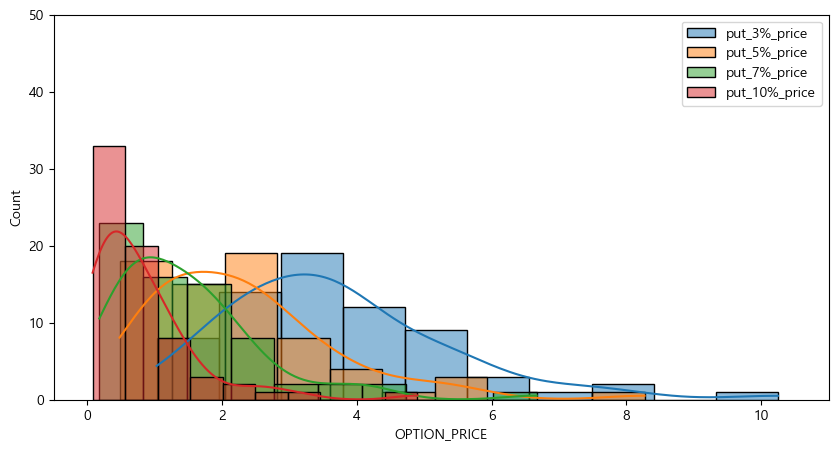

In [407]:
plt.figure(figsize=(10,5))
sns.histplot(kospi200_selected['put_3%_price'], bins=10, kde=True, label='put_3%_price') 
sns.histplot(kospi200_selected['put_5%_price'], bins=10, kde=True, label='put_5%_price') 
sns.histplot(kospi200_selected['put_7%_price'], bins=10, kde=True, label='put_7%_price') 
sns.histplot(kospi200_selected['put_10%_price'], bins=10, kde=True, label='put_10%_price')
plt.xlabel('OPTION_PRICE')
plt.xlim(-0.5,11)
plt.ylim(0,50)
plt.legend()

In [ ]:
otm_call=['3%','5%','7%','10%'] # 콜옵션 OTM 비율 --> ###%%% 주요변수 입력 창 ######
for otm in otm_call:
    kospi200_selected[f'dual_{otm}_result']=kospi200_selected[f'call_{otm}_result'] + kospi200_selected[f'put_{otm}_result']

Text(0.5, 0, 'YEAR')

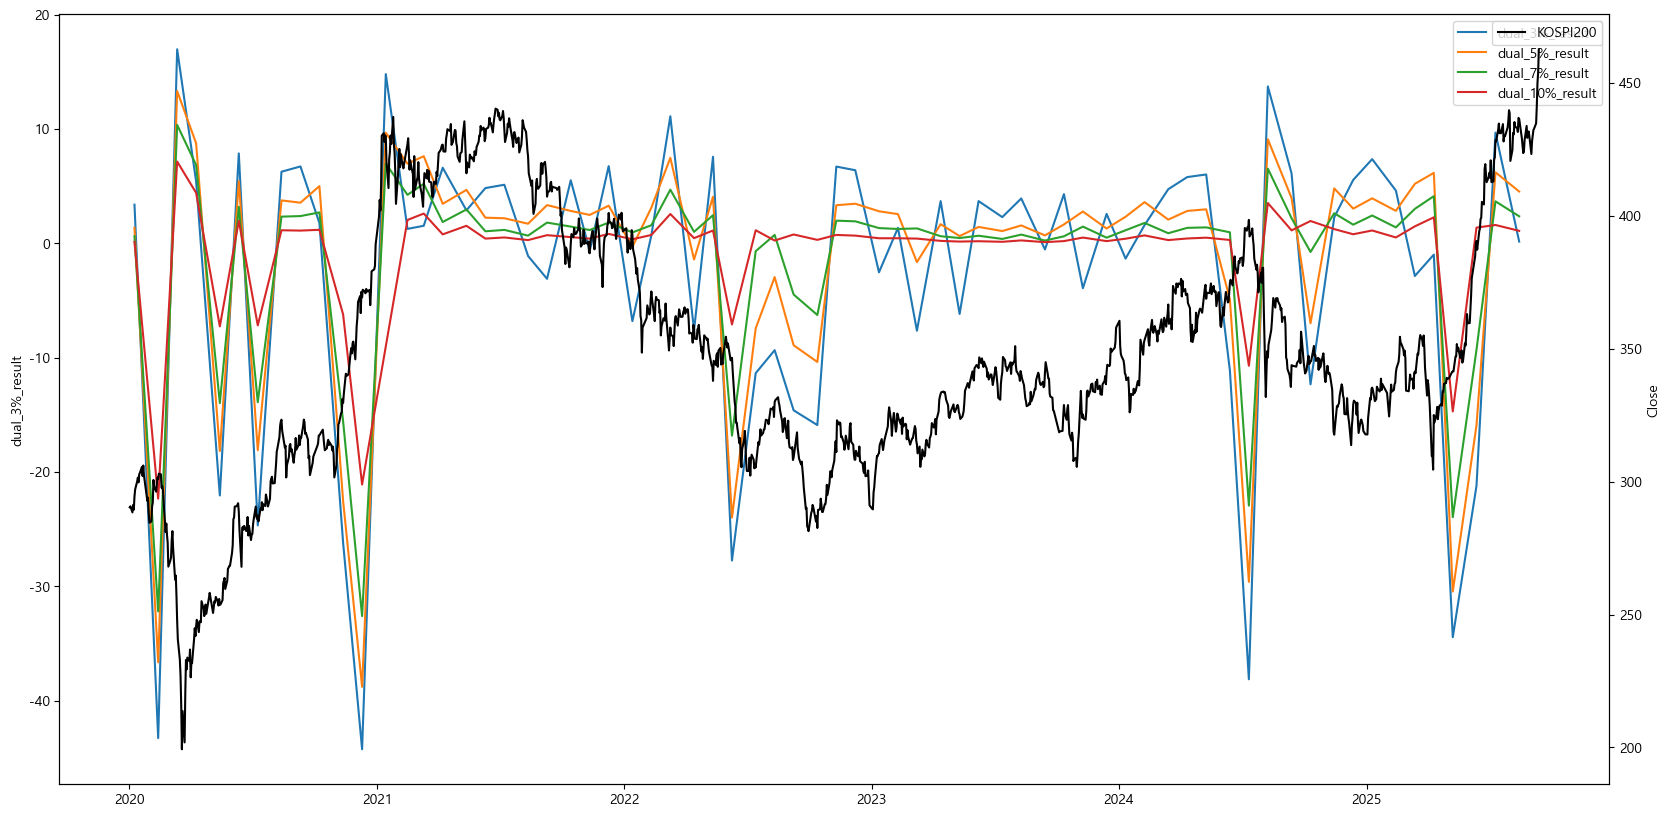

In [367]:
selected=[ k for k in kospi200_selected.columns if 'dual' in k ]
plt.figure(figsize=(20,10))     
for i in range(len(selected)):
    sns.lineplot(data=kospi200_selected, x=kospi200_selected.index, y=selected[i], label=selected[i])
ax2=plt.twinx()
sns.lineplot(kospi200, x=kospi200.index, y='Close', color='black', label='KOSPI200')
plt.xlabel('YEAR')

In [368]:
kospi200_selected

,Close,High,Low,Open,Volume,call_3%,call_5%,call_7%,call_10%,call_3%_price,...,put_7%_price,put_10%_price,put_3%_result,put_5%_result,put_7%_result,put_10%_result,dual_3%_result,dual_5%_result,dual_7%_result,dual_10%_result
2020-01-09,294.410004,294.410004,292.100006,293.829987,111800000,302.5,310.0,315.0,325.0,1.85,...,0.40,0.10,1.530000,0.780000,0.400000,0.100000,3.380000,1.360000,0.620000,0.130000
2020-02-13,300.929993,304.429993,300.480011,302.790009,115100000,310.0,315.0,322.5,330.0,1.60,...,0.70,0.26,-44.880005,-37.380005,-32.380005,-22.380005,-43.280005,-36.650005,-32.200005,-22.340005
2020-03-12,247.619995,255.490005,243.759995,253.929993,242500000,255.0,260.0,265.0,272.5,6.72,...,6.67,4.90,10.250000,8.270000,6.670000,4.900000,16.970000,13.320000,10.360000,7.150000
2020-04-09,245.610001,246.460007,243.110001,246.130005,175900000,252.5,257.5,262.5,270.0,5.45,...,4.26,3.15,6.560000,5.160000,4.260000,3.150000,5.410006,8.750000,6.850000,4.410000
2020-05-14,253.649994,254.389999,252.089996,253.259995,167600000,262.5,267.5,272.5,280.0,2.03,...,2.14,1.35,4.060000,2.950000,2.140000,1.350000,-22.059995,-18.169995,-13.979995,-7.269995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,341.470001,343.549988,341.429993,342.440002,124200000,352.5,357.5,365.0,375.0,2.92,...,1.66,0.91,3.660000,2.660000,1.660000,0.910000,-34.459995,-30.459995,-23.959995,-14.709995
2025-06-12,390.619995,393.019989,389.459991,390.109985,219800000,402.5,410.0,417.5,430.0,4.13,...,1.61,0.91,4.710000,2.510000,1.610000,0.910000,-21.210013,-15.910013,-9.310013,1.370000
2025-07-10,428.420013,428.420013,421.880005,423.429993,158400000,442.5,450.0,457.5,472.5,4.50,...,2.00,1.04,5.180000,3.450000,2.000000,1.040000,9.680000,6.210000,3.670000,1.600000
2025-08-14,436.570007,438.660004,434.519989,436.929993,136000000,450.0,457.5,467.5,480.0,3.32,...,1.60,0.82,4.150000,2.720000,1.600000,0.820000,0.150000,4.530000,2.360000,1.090000


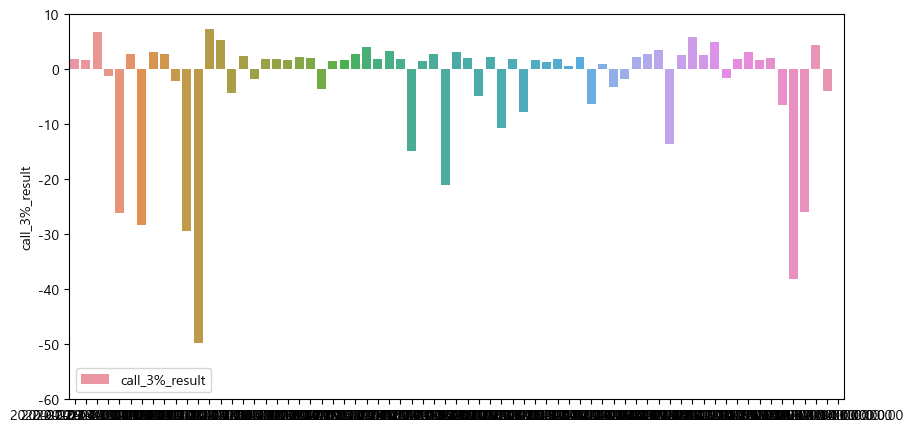

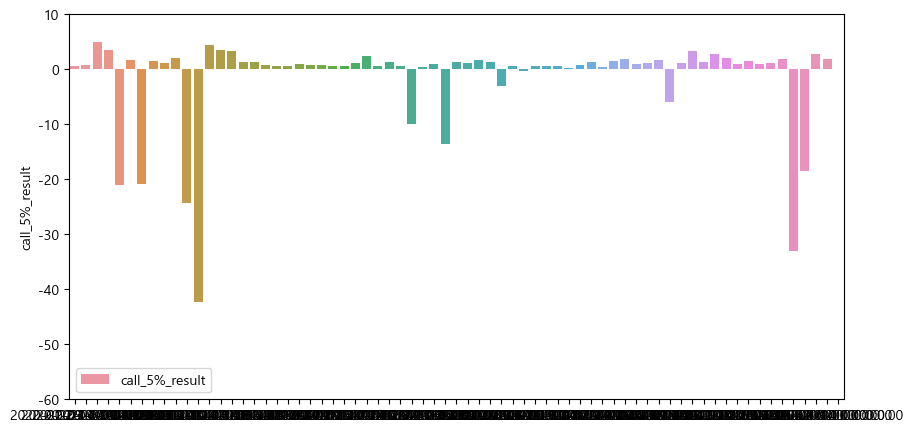

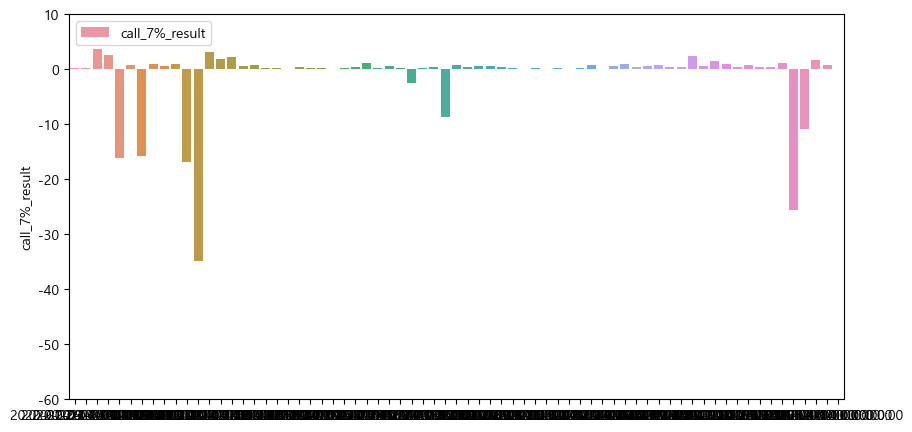

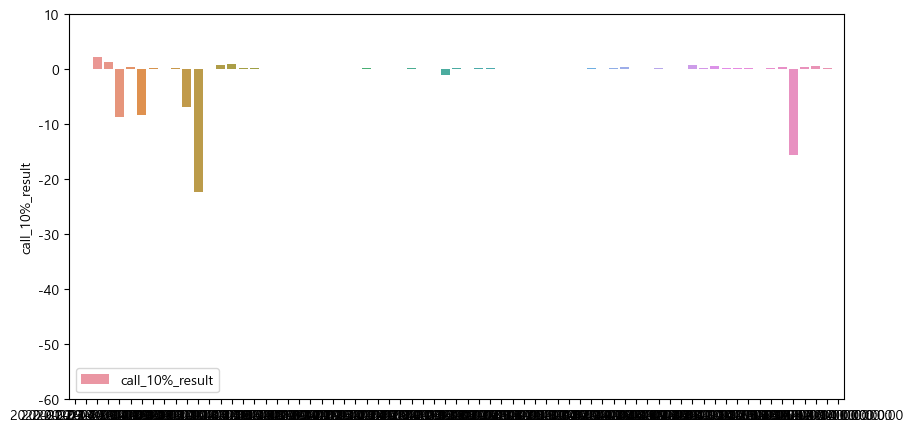

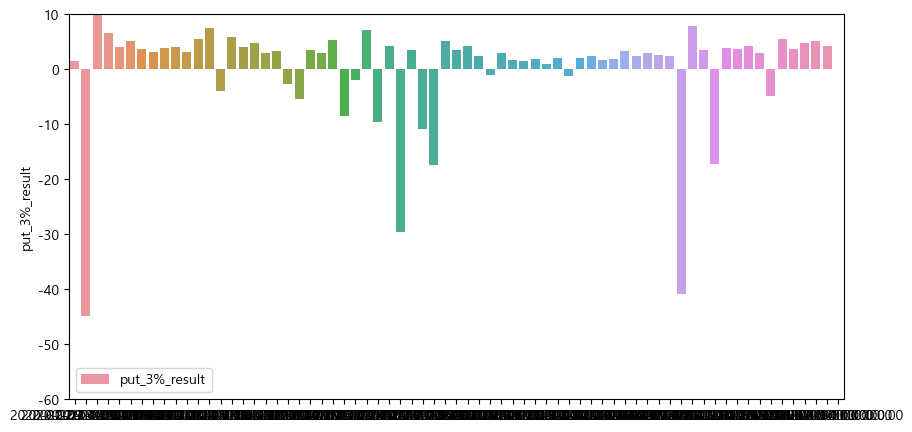

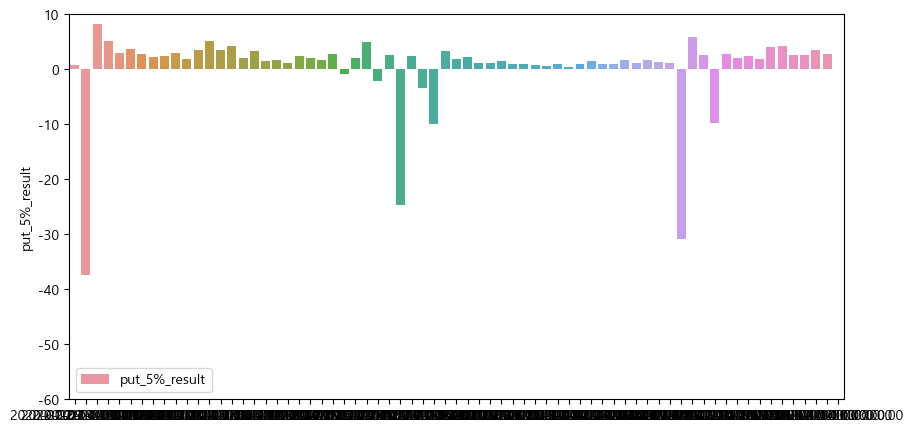

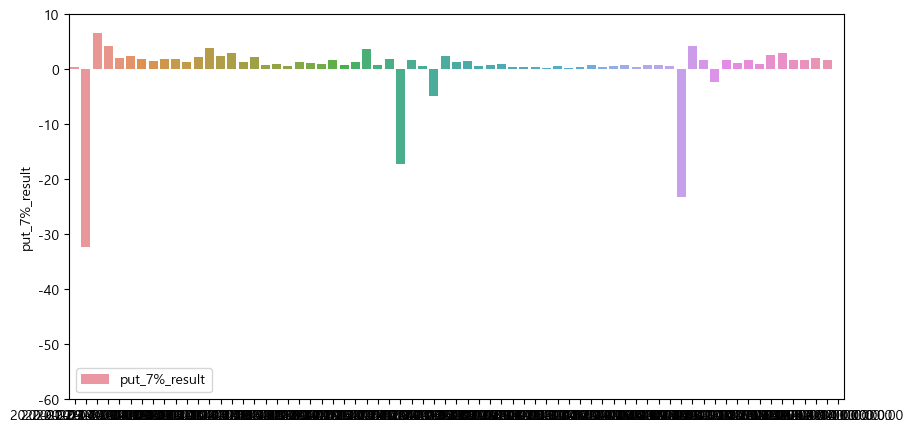

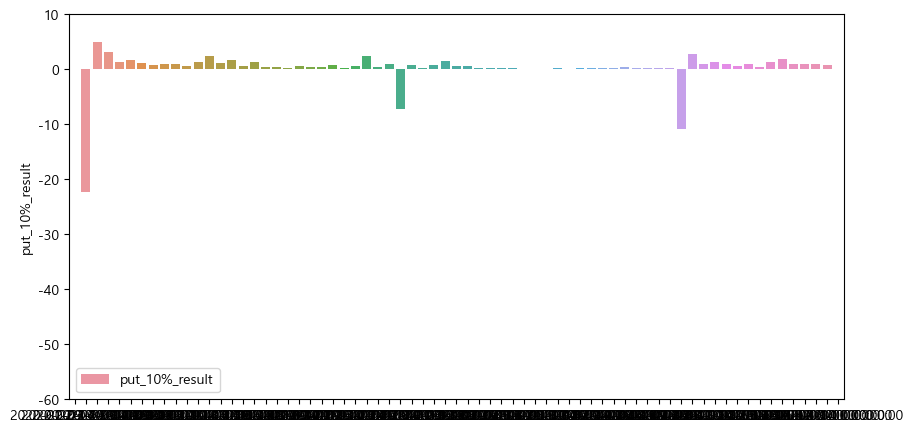

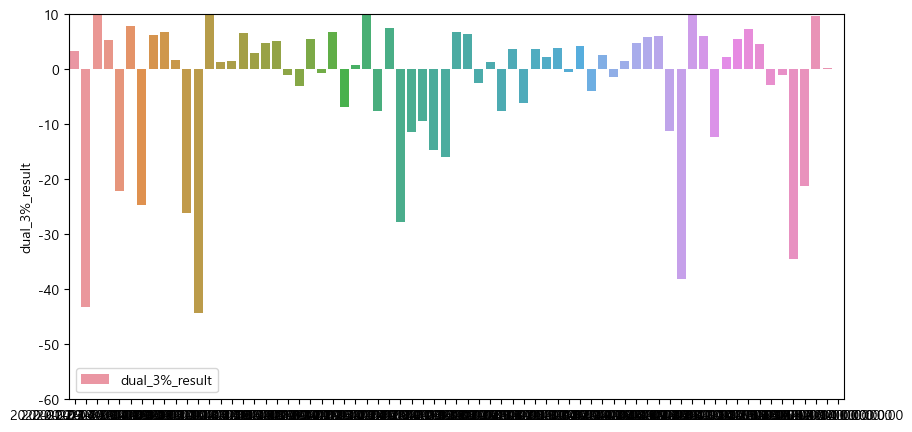

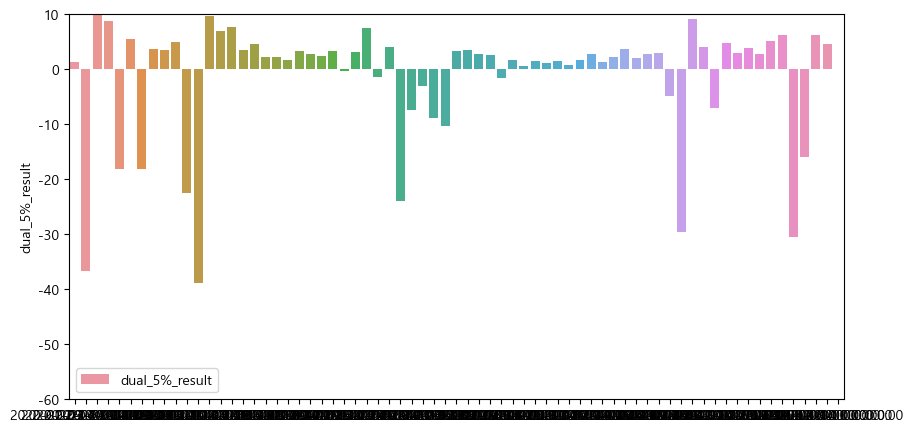

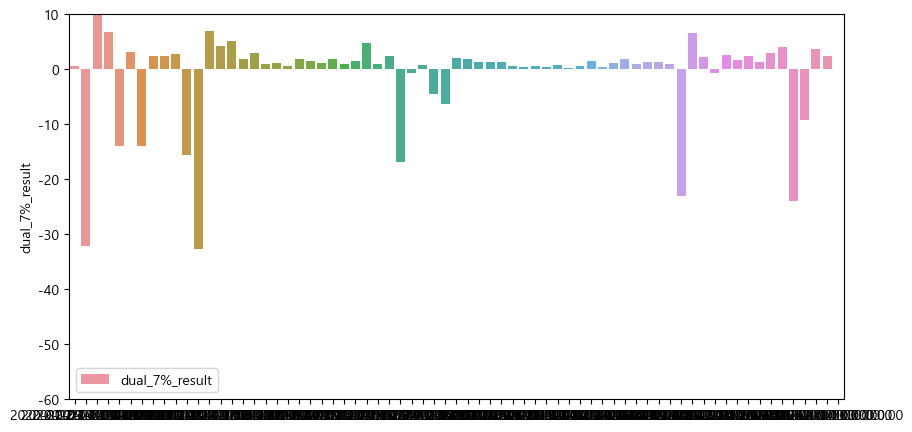

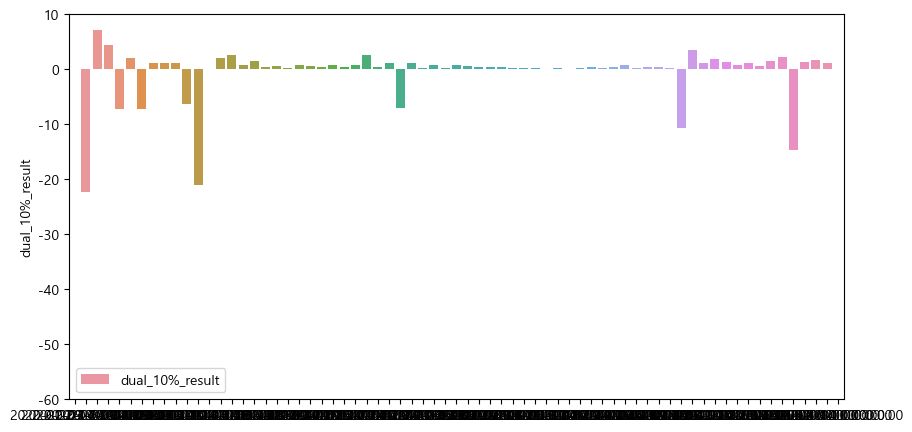

In [377]:
graph = [ l for l in kospi200_selected.columns if 'result' in l ]
for g in graph:
    plt.figure(figsize=(10,5))
    sns.barplot(data=kospi200_selected, x=kospi200_selected.index, y=g, label=g)
    plt.legend()
    plt.ylim(-60,10)

In [ ]:
def get_option_price(column_name):
    price_name=[]
    for i in range(len(kospi200_selected)):
        price_code=(kospi200_selected.index[i]+pd.Timedelta(days=30)).strftime('%Y%m')+str(' ')+str(kospi200_selected[column_name][i])
        price_codes = '코스피200 C'+str(' ')+price_code+str(' (주간)')
        price_name.append(price_codes)

    price_list=[]
    for j in range(len(price_name)):
        price=option_price_data[dates[j]][option_price_data[dates[j]]['종목명'] == price_name[j]]['종가'].values
        if len(price)==0:
            price=np.nan
        else:
            price=price[0]
        price_list.append(price)

    df_price_tmp=pd.DataFrame(price_list, columns=[f'{column_name}_price'], index=kospi200_selected.index)
    return df_price_tmp   

In [ ]:
put_price=kospi200_selected[col_name2]
put_price=put_price.asfreq('D', method='ffill')


<Axes: ylabel='put_7%_price'>

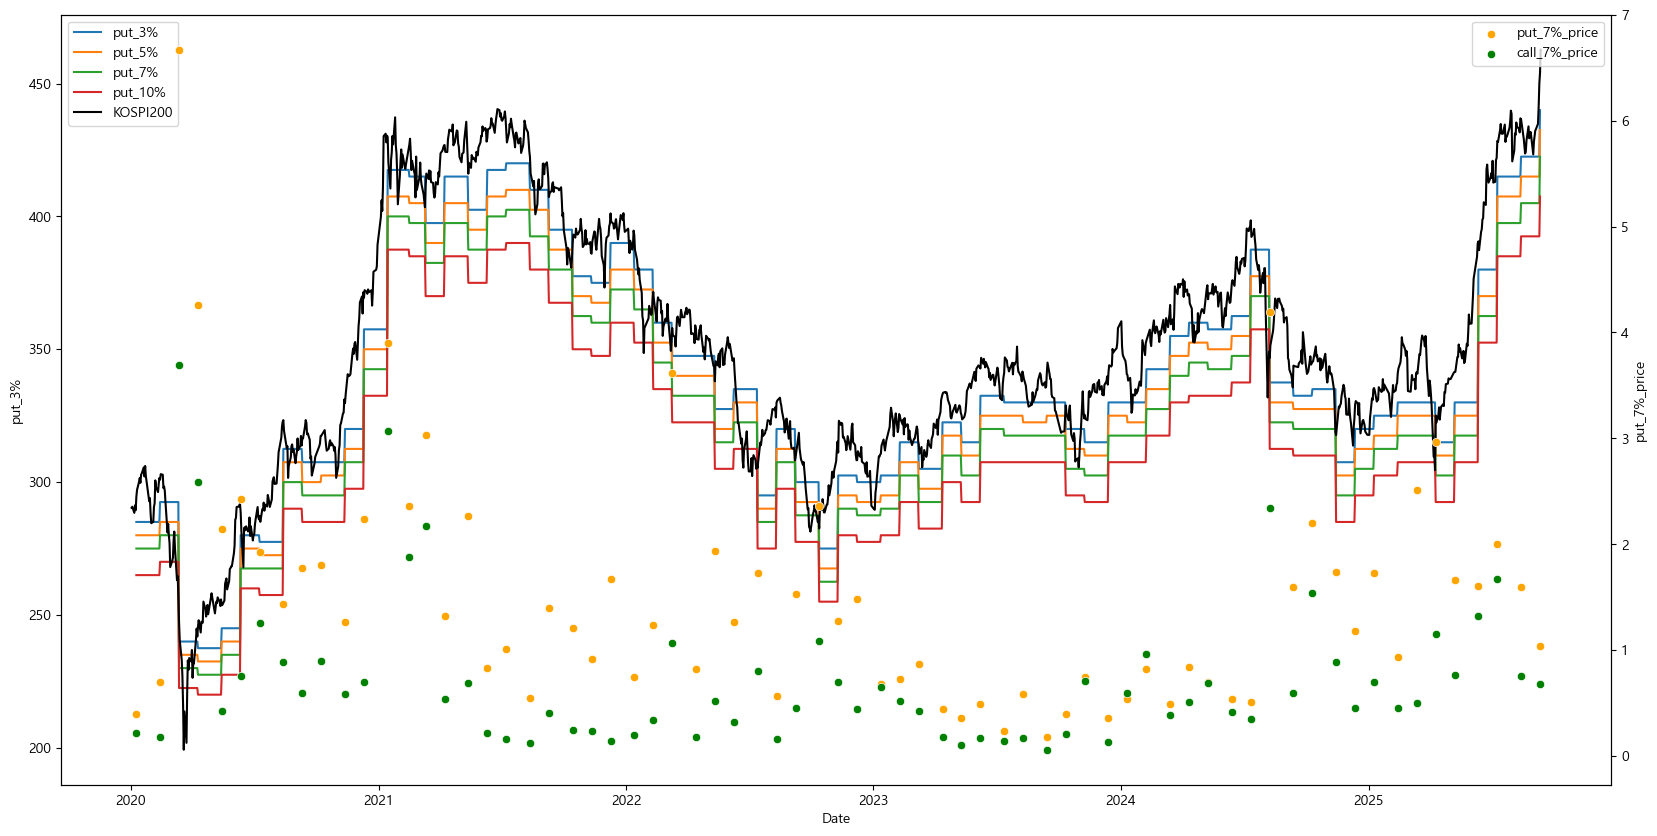

In [400]:
plt.figure(figsize=(20,10))
for name in col_name2:
    
    sns.lineplot(data=put_price, x=put_price.index, y=name, label=name)
    plt.legend()

sns.lineplot(kospi200, x=kospi200.index, y='Close', color='black', label='KOSPI200')
ax2=plt.twinx()
sns.scatterplot(data=kospi200_selected, x=kospi200_selected.index, y='put_7%_price', color='orange', label='put_7%_price', ax=ax2)
sns.scatterplot(data=kospi200_selected, x=kospi200_selected.index, y='call_7%_price', color='green', label='call_7%_price', ax=ax2)